<a href="https://colab.research.google.com/github/ggoggori/Dacon/blob/main/2021_Ego_Vision_%EC%86%90%EB%8F%99%EC%9E%91_%EC%9D%B8%EC%8B%9D_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torchsummary
!pip install efficientnet_pytorch
!mkdir ./data
!mkdir ./data/jsons
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/데이콘/손동작 인식/data/open.zip" -d "./data"
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/데이콘/손동작 인식/data/new_jsons.zip" -d "./data/jsons"

In [ ]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
import PIL
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing import image as tfimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
from torchsummary import summary


# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import re
import time
import random
from google.colab import files
import inspect

In [ ]:
class config:
    # info
    n_classes = 157
    target_size = None
    use_cache = True
    random_seed = 4
    
    #processing
    del_noise = False
    
    # training
    CV = False
    if CV:
        fold = 5
    else:
        fold = 1

    lr = 0.0002
    num_epochs = 300
    batch_size = 32
    patience = 100
    apply_scheduler = False
    scheduler = 'plateau'  #plateau #cyclic
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # model
    pretrained = True
    frezzing = False
    model_name = 'densenet'
    model_path = '/content/drive/MyDrive/Colab Notebooks/데이콘/손동작 인식/model111'

In [ ]:
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(config.random_seed)
random.seed(config.random_seed)

In [ ]:
data_path = '/content/data'
json_path = '/content/data/jsons'

train_path = data_path + '/train'
test_path = data_path + '/test'
train_jsonpath = json_path + '/train'
test_jsonpath = json_path + '/test'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_jsons = sorted(glob(train_jsonpath + '/*'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
test_jsons = sorted(glob(test_jsonpath + '/*'), key = lambda x: int(x.split('/')[-1].split('.')[0]))

In [ ]:
answers = []
for train_folder, json_path  in zip(train_folders, train_jsons) :
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1]
    answers.append([train_folder.replace(data_path,''),cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])

## 각 label에 따른 image sample 확인

In [ ]:
ex_target = []
inve_list = []
for json_path in train_jsons:
    target = json.load(open(json_path))['action'][0]
    if target in ex_target:
        continue
    else:
        ex_target.append(target)
        inve_list.append(int(re.findall("\d+", json_path)[0]))

In [ ]:
ex_path = '/content/data/train/{}/0.png'
for folder_id, label in zip(inve_list, ex_target):
    image = tfimage.load_img(ex_path.format(folder_id), target_size=(600,600,3))
    plt.imshow(image)
    plt.title(answers[answers['answer'] == label]['answer_name'].to_list()[0])
    plt.show()



## crop image 확인

In [ ]:
def get_sliced_img(image: np.array, keypoints: np.array, return_type: str=None, return_size: tuple=None) -> np.array:     
    ## Get points.
    max_point = np.max(np.array(keypoints), axis=0).astype(int) + 100
    min_point = np.min(np.array(keypoints), axis=0).astype(int) - 100
    max_point = max_point[:-1] # remove Z order
    min_point = min_point[:-1] # remove Z order

    max_x, max_y = max_point
    min_x, min_y = min_point

    # 데이터 포인트의 크기가 원 이미지를 넘어서는 경우를 방지
    max_x = max_x if max_x < 1920 else 1920
    max_y = max_y if max_y < 1080 else 1080
    min_x = min_x if min_x > 0 else 0
    min_y = min_y if min_y > 0 else 0

    ## Slice.
    image = image[min_y:max_y, min_x:max_x]

    if return_size is not None and return_type is None:
        raise Exception('set return_type parameter')

    if return_type == 'PIL':
        image = Image.fromarray(image.astype(np.uint8)) 
        if return_size is not None:
            image = image.resize(return_size)
            
    elif return_type == 'array' and return_size is not None:
        image = tfimage.smart_resize(image, return_size)

    return image
    
#https://dacon.io/competitions/official/235805/codeshare/3321?page=1&dtype=recent

# EDA

In [ ]:
train_folder = train_folders[0]
image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
json_path   = train_jsons[0]

(1080, 1920, 3)


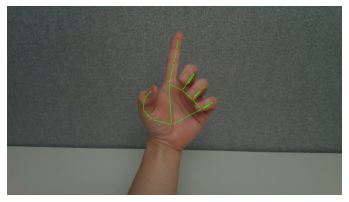

In [ ]:
image_path = image_paths[0]
img = PIL.Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

In [ ]:
js = json.load(open(json_path))

print("json keys              : ", js.keys())

print("json action info       : ",js.get('action'))

print("json actor info        : ",js.get('actor'))

print("json annotations keys  : ",js.get('annotations')[0].keys())

json keys              :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info       :  [0, '숫자 1']
json actor info        :  None
json annotations keys  :  dict_keys(['image_id', 'data'])


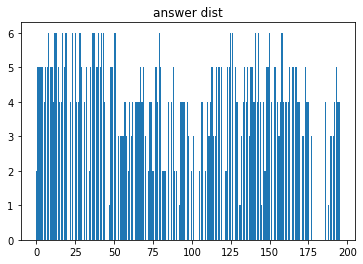

In [ ]:
plt.bar(answers['answer'].value_counts().index, answers['answer'].value_counts().values)
plt.title('answer dist')
plt.show()

# move coordinates

In [ ]:
def move_coordinates(keypoints, imgsize):
    Rx = imgsize[1]/1920
    Ry = imgsize[0]/1080
    keypoints[:21,0] = keypoints[:21,0] * Rx
    keypoints[:21,1] = keypoints[:21,1] * Ry

    return keypoints

# dataset, dataloader

In [ ]:
class VisionDataset(Dataset):
    def __init__(self, image_paths, classes, transform=None, crop=None, target_size=None, use_cache=False):
        self.image_paths = image_paths
        self.crop = crop
        self.transform = transform
        self.classes = classes
        self.target_size= target_size
        self.use_cache = use_cache
        # https://discuss.pytorch.org/t/best-practice-to-cache-the-entire-dataset-during-first-epoch/19608/6
        self.cached_data = []
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if not self.use_cache:
            image_path = self.image_paths[idx]
            folder_id, image_id = re.findall("\d+", image_path)
            json_pathlist = ['/content/data/jsons', 'train', folder_id]
            json_path = os.path.join(*json_pathlist) + '.json'
            js = json.load(open(json_path))
        
            image = tfimage.load_img(image_path, target_size=self.target_size)
            label = self.classes[int(folder_id)]

            if self.transform is not None:
                image = self.transform(image)

            self.cached_data.append([image, label])

        else:
            image, label = self.cached_data[idx]

        return image, label

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache

class VisionTestDataset(Dataset):
    def __init__(self, image_paths, transform=None, crop=None, target_size=None):
        self.image_paths = image_paths
        self.crop = crop
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        folder_id, image_id = re.findall("\d+", image_path)
        json_pathlist = ['/content/data/jsons', 'test', folder_id]
        json_path = os.path.join(*json_pathlist) + '.json'
        js = json.load(open(json_path))
    
        image = tfimage.load_img(image_path, target_size=self.target_size)
    
        if self.transform is not None:
            image = self.transform(image)
    
        return image

def make_image_path(folders, noise=None):
    total_path = []
    for folder in folders:
        image_paths = sorted(glob(folder + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
        if noise is not None:
            image_paths = [path for path in image_paths if path not in noise]
        total_path.extend(image_paths)
    
    return total_path

def prepare_dataloader(train_index, valid_index):
    train_image_path = np.array(org_train_image_path)[train_index]
    valid_image_path = np.array(org_train_image_path)[valid_index]
    
    train_dataset = VisionDataset(train_image_path, classes, transform=transforms_train, target_size=config.target_size, use_cache=False)
    valid_dataset = VisionDataset(valid_image_path, classes, transform=transforms_test, target_size=config.target_size, use_cache=False)
    test_dataset = VisionTestDataset(test_image_path, transform=transforms_test, target_size=config.target_size)

    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=0, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=config.batch_size, num_workers=0, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=0, shuffle=False)
    
    return train_dataloader, valid_dataloader, test_dataloader

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(256), transforms.RandomCrop((224, 420)),
    transforms.RandomAffine(11),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.2),     
    transforms.ColorJitter(contrast=(0.8, 3)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.3006, 0.3037, 0.2713],std=[0.1863, 0.1622, 0.1355])
])

transforms_test = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop((224, 420)), 
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.3006, 0.3037, 0.2713],std=[0.1863, 0.1622, 0.1355])
])

In [ ]:
# 강 '81/9.png', '473/5.png' , '526/0.png	' ,'183/0.png',
# 중 '266/7.png','266/8.png','266/9.png', '583/7.png'
# 약

if config.del_noise == True:
    # noise = ['/content/data/train/81/9.png','/content/data/train/183/0.png','/content/data/train/266/7.png',\
    #         '/content/data/train/266/8.png','/content/data/train/266/9.png'\
    #         '/content/data/train/473/5.png', '/content/data/train/526/0.png','/content/data/train/583/7.png']
    noise = ['/content/data/train/81/9.png', '/content/data/train/183/0.png', '/content/data/train/473/5.png', '/content/data/train/526/0.png']
else: noise = None

In [ ]:
classes = np.argmax(pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy(), axis=1)
org_train_image_path = make_image_path(train_folders, noise)
test_image_path = make_image_path(test_folders)

In [ ]:
len(org_train_image_path)

5887

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self, mode='train', fold=1):
        super(Model, self).__init__()
        self.mode = mode
        self.fold = fold
        self.model_name = config.model_name
        self.model = self.get_model(self.model_name)
        
        
    def forward(self, x):
        x = self.model(x)
        
        return x
        
    def get_model(self, model_name):
        if 'efficientnet' in model_name:
            if config.pretrained:
                model = EfficientNet.from_pretrained(model_name)
            else: 
                model = EfficientNet.from_name(model_name)
            
            num_ftrs = model._fc.in_features
            model._fc = nn.Linear(num_ftrs, config.n_classes)
            
        elif 'resnet' in model_name:
            model = models.resnet18(pretrained=config.pretrained)
                
            num_ftrs = model.fc.in_features
            classifier = nn.Sequential(nn.Linear(num_ftrs, config.n_classes))
            model.fc = classifier
        
        elif 'densenet' in model_name:
            model = models.densenet161(pretrained=True)
            num_ftrs = model.classifier.in_features
            classifier = nn.Sequential(nn.Linear(num_ftrs, config.n_classes))
            model.classifier = classifier
        
        if config.frezzing == True:
                for param in model.parameters():
                    param.requires_grad = False

        if self.mode == 'test':
                model.load_state_dict(torch.load(os.path.join(config.model_path,'model_{}'.format(self.fold)+'weight.pt')))
                
        model = model.to(config.device)

        return model

# train

In [ ]:
def make_submission(model, test_image_path):
    sample_submission = pd.read_csv(data_path + '/sample_submission.csv')
    predictions = []
    model.eval()
    for inputs in test_dataloader:
        with torch.no_grad():
            inputs = inputs.to(config.device)
            output = F.softmax(model(inputs), dim=1).cpu().detach().numpy()
            predictions.extend(output)
            
    df = pd.DataFrame(0, index=np.arange(len(test_image_path)), columns=sample_submission.columns)
    df['Image_Path'] = test_image_path
    df.iloc[:,1:] = np.array(predictions)
    df['folder_num'] = df['Image_Path'].map(lambda x: x.split('/')[-2])
    df = df.groupby('folder_num').mean().reset_index()
    
    sample_submission.iloc[:,1:] = df
    
    return sample_submission

In [ ]:
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'valid_loss':[], 'valid_acc':[]}
os.makedirs(config.model_path, exist_ok=True)

In [ ]:
obj=config()
for i in inspect.getmembers(obj):
    if '__' not in i[0]:
        print(i)

y = []
for path  in org_train_image_path:
    folder_id, image_id = re.findall("\d+", path)
    json_pathlist = ['/content/data/jsons', 'train', folder_id]
    json_path = os.path.join(*json_pathlist) + '.json'
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    y.append(cat)

submits = []
sss = StratifiedShuffleSplit(n_splits=config.fold, test_size=.2, random_state=config.random_seed)
indices = range(len(org_train_image_path))

for fold, (train_index, valid_index) in enumerate(sss.split(indices, y), 1):
    print('fold: {}'.format(fold))
    print('#'*40)

    train_dataloader, valid_dataloader, test_dataloader = prepare_dataloader(train_index, valid_index)
    model = Model(mode='train')

    best_val_loss, extra_best_val_loss, patience = 1000, 0, 0
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=20, threshold = 0.001,\
                                                    verbose=True, min_lr = 1e-5, threshold_mode = 'abs')
    # scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.0001, step_size_up=20, cycle_momentum=False, \
    #                                         step_size_down=None,  mode='exp_range', gamma=0.995, verbose=True)

    for epoch in range(0, config.num_epochs):
        start = time.time()
        model.train()
        current_loss, correct ,total = 0,0,0
        print(f'Starting epoch [{epoch+1}/{config.num_epochs}]')

        if epoch == 1 and config.use_cache == True:
            train_dataloader.dataset.set_use_cache(use_cache=True)
            train_dataloader.num_workers = 4
            valid_dataloader.dataset.set_use_cache(use_cache=True)
            valid_dataloader.num_workers = 4

        for inputs, targets in train_dataloader:

            inputs = inputs.to(config.device)
            targets = targets.type(torch.LongTensor).to(config.device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
            total += targets.size(0)
            _, pred = torch.max(output, 1)
            correct += (pred==targets).sum()
            
        train_acc = correct.cpu().numpy()/total
        print('[train] ACC:{} / loss:{}'.format(round(train_acc,5),current_loss)) 
        history['train_loss'].append(current_loss)
        history['train_acc'].append(train_acc)    

##############################validation########################################      
        model.eval()
        valid_loss, correct ,total = 0,0,0

        with torch.no_grad():
            for inputs, targets in valid_dataloader:
                inputs = inputs.to(config.device)
                targets = targets.type(torch.LongTensor).to(config.device)
                output = model(inputs)
                loss = criterion(output, targets)
                valid_loss += loss.item() 
                _, predicted = torch.max(output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum()
            valid_acc = correct.cpu().numpy()/total
        
            print('[valid] ACC:{} / loss:{}'.format(round(valid_acc, 5), valid_loss))
            
            history['valid_loss'].append(valid_loss)
            history['valid_acc'].append(valid_acc)

    ##########scheduler###########   
        if config.apply_scheduler == True and config.scheduler == 'cyclic':
            scheduler.step()
        elif config.apply_scheduler == True and config.scheduler == 'plateau':
            scheduler.step(best_val_loss)

    ######## save best model########
        if (valid_loss < best_val_loss) and (current_loss < valid_loss) :
            best_val_loss = valid_loss
            patience = 0
            torch.save(model.model.state_dict(), os.path.join(config.model_path,'model_{}'.format(fold) +'weight.pt'))
            print(f'model saved at {epoch} epoch')

        elif (valid_loss < best_val_loss) and (current_loss > valid_loss) :
            difference = current_loss - valid_loss
            if difference < 0.1:
                best_val_loss = valid_loss
                patience = 0
                torch.save(model.model.state_dict(), os.path.join(config.model_path,'model_{}'.format(fold) +'weight.pt'))
                print(f'model saved at {epoch} epoch')

            else:
                patience += 1
                print("Counter {} of {}".format(patience, config.patience))

                if patience >= config.patience:
                    print("Early stopping with best_loss: ", best_val_loss, "and valid_loss for this epoch: ", valid_loss, "...")
                    break
 
        else:
            patience += 1
            print("Counter {} of {}".format(patience, config.patience))

            if patience >= config.patience:
                print("Early stopping with best_loss: ", best_val_loss, "and valid_loss for this epoch: ", valid_loss, "...")
                break
        
        if valid_loss < extra_best_val_loss:
            extra_best_val_loss = valid_loss
            extra_model = model

        end = time.time() 
        print(f'--------------"{end - start:.5f} sec"-----------------')   

    if os.path.isfile(os.path.join(config.model_path,'model_{}'.format(fold) +'weight.pt')) == False:
        torch.save(extra_model.model.state_dict(), os.path.join(config.model_path,'model_{}'.format(fold) +'weight.pt'))

############################test#########################################
    model = Model(mode='test', fold=fold)
    submit = make_submission(model, test_image_path)
    if config.CV == True:
        submits.append(submit)    

('CV', False)
('apply_scheduler', False)
('batch_size', 32)
('del_noise', False)
('device', 'cuda')
('fold', 1)
('frezzing', False)
('lr', 0.0002)
('model_name', 'densenet')
('model_path', '/content/drive/MyDrive/Colab Notebooks/데이콘/손동작 인식/model111')
('n_classes', 157)
('num_epochs', 300)
('patience', 100)
('pretrained', True)
('random_seed', 4)
('scheduler', 'plateau')
('target_size', None)
('use_cache', True)
fold: 1
########################################


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Starting epoch [1/300]
[train] ACC:0.48439 / loss:418.5167614221573
[valid] ACC:0.82258 / loss:36.17027121782303
Counter 1 of 100
--------------"632.11313 sec"-----------------
Starting epoch [2/300]
[train] ACC:0.9278 / loss:79.29211255908012
[valid] ACC:0.95501 / loss:8.169994220137596
Counter 2 of 100
--------------"135.02990 sec"-----------------
Starting epoch [3/300]
[train] ACC:0.98004 / loss:25.255681969225407
[valid] ACC:0.97878 / loss:4.904477823525667
Counter 3 of 100
--------------"135.09213 sec"-----------------
Starting epoch [4/300]
[train] ACC:0.99023 / loss:12.0797738134861
[valid] ACC:0.9584 / loss:7.269909396767616
Counter 4 of 100
--------------"135.07581 sec"-----------------
Starting epoch [5/300]
[train] ACC:0.98705 / loss:13.532229594886303
[valid] ACC:0.98387 / loss:2.764399640262127
Counter 5 of 100
--------------"134.98531 sec"-----------------
Starting epoch [6/300]
[train] ACC:0.98535 / loss:13.217351622879505
[valid] ACC:0.9966 / loss:0.9411604977212846
Co

# infenrence

In [ ]:
# for index, (train_index, valid_index) in enumerate(sss.split(indices, y), 1):
#     print(1)
# train_dataloader, valid_dataloader, test_dataloader = prepare_dataloader(train_index, valid_index)
submits = []

for fold in [1]:
    model = Model(mode='test', fold=fold)
    submit = make_submission(model, test_image_path)
    if config.CV == True:
        submits.append(submit)   

Loaded pretrained weights for efficientnet-b2


In [ ]:
if config.CV == False:
    submit.to_csv('./BASELINE.csv', index=False)
elif config.CV == True:
    tt = submits[0] + submits[1] + submits[2] + submits[3] + submits[4]
    tt['Image_Path'] = submits[0]['Image_Path']
    tt.iloc[:,1:] = tt.iloc[:,1:] / config.fold
    tt.to_csv('./BASELINE.csv', index=False)

files.download('./BASELINE.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# resluts

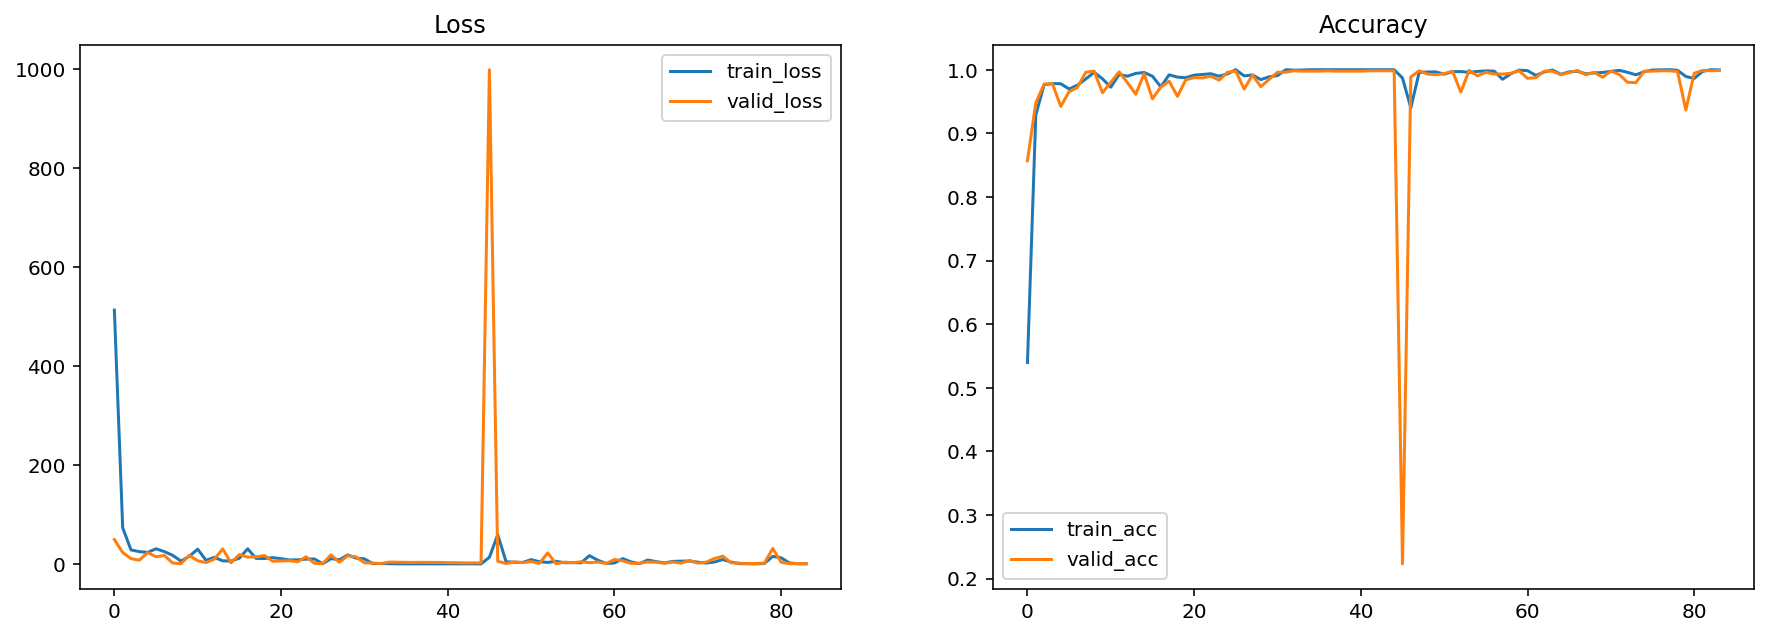

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize=(15,5))

axes[0].plot(history['train_loss'], label='train_loss')
axes[0].plot(history['valid_loss'],label='valid_loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history['train_acc'], label='train_acc')
axes[1].plot(history['valid_acc'], label='valid_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()